In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
from torch import nn
from simulators import SimulatorBlob

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
NPIX = 64
bounds = None

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


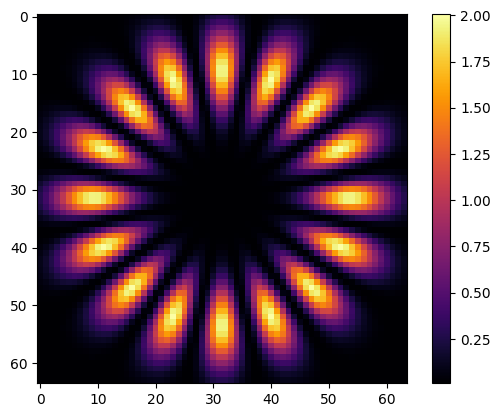

In [4]:
def gen_target_image(Npix):
    l = torch.linspace(-1, 1, Npix)
    L1, L2 = torch.meshgrid(l, l)
    R = (L1**2+L2**2)**0.5
    t = torch.exp(-(R-0.7)**2/2/0.15**2)
    t *= torch.cos(torch.arctan2(L1, L2)*16)+1
    return t+0.01

z0 = gen_target_image(Npix = NPIX)
torch.save(z0, 'task2_target_image.pt')
z0 = torch.load("task2_target_image.pt")
plt.imshow(z0, cmap = 'inferno')
plt.colorbar()

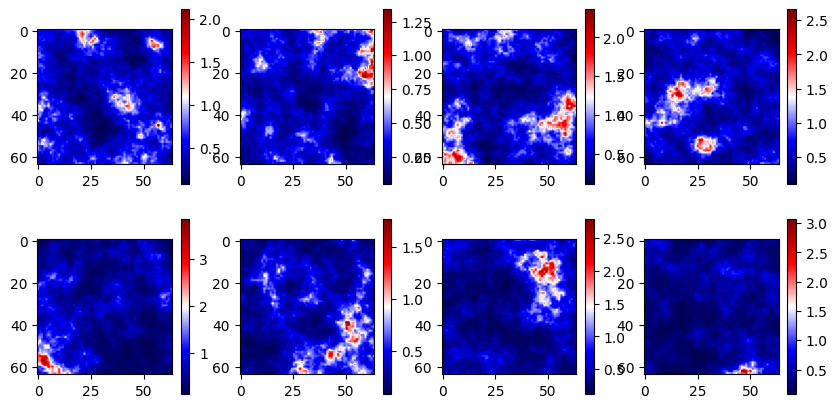

In [5]:
sim = SimulatorBlob(Npix = NPIX, bounds = bounds, sigma = 0.3)
plt.figure(figsize = (10, 5))
for i in range(1, 9):
    plt.subplot(2, 4, i)
    sample = sim.sample()
    t = sample['mu']
    plt.imshow(t, cmap = 'seismic')
    plt.colorbar()

In [6]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, Npix = NPIX):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-3, lrs_factor=0.3, lrs_patience=3)
        self.num_params = Npix**2
        self.lre = swyft.LogRatioEstimator_Gaussian_Autoregressive_X(Npix**2, "mu", minstd = 1e-3, momentum = 0.1)
        self.Npix = Npix

    def forward(self, A, B):
        xA = A["mu"]
        fA = xA.view(-1, self.Npix**2)
        xB = B["mu"]
        fB = xB.view(-1, self.Npix**2)
        zB = B['z'].view(-1, self.Npix*self.Npix)
        result = self.lre(fA, fB, zB)
        return result

In [9]:
def next_round(sample0, bounds = None, Nsims = 1024):
    sim = SimulatorBlob(bounds = bounds, Npix = NPIX, sigma = .01)
    samples = sim.sample(Nsims)
    dl = swyft.SwyftDataModule(samples, fractions = [0.8, 0.2, 0], batch_size = 256)
    trainer = swyft.SwyftTrainer(accelerator = 'gpu', max_epochs = 10, precision = 32)
    network = Network(Npix = NPIX)
    trainer.fit(network, dl)
    x = z0.view(-1).cuda()
    draws = network.lre.get_post_samples(2048, x, sim.Cov, gamma = 0.2).view(-1, NPIX, NPIX)
    return network, draws

In [31]:
sim = SimulatorBlob(bounds = bounds, Npix = NPIX, sigma = .01)
samples = sim.sample(Nsims)
dl = swyft.SwyftDataModule(samples, fractions = [0.8, 0.2, 0], batch_size = 256)
trainer = swyft.SwyftTrainer(accelerator = 'gpu', max_epochs = 10, precision = 32)
network = Network(Npix = NPIX)
trainer.fit(network, dl)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:00<00:00, 3937.34it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                        | Params
---------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Gaussian_Autoregressive_X | 50.3 M
---------------------------------------------------------------------
16.8 M    Trainable params
33.6 M   

Epoch 0:  80%|███████████████████████████████████████████████████▏            | 4/5 [00:00<00:00, 24.48it/s, loss=-8.38e+03, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 1:  80%|████████████████████████████████████         | 4/5 [00:00<00:00, 24.94it/s, loss=-8.39e+03, v_num=7, val_loss=-8.42e+3]
Validation: 0it [00:00, ?it/s]
Epoch 2:  80%|████████████████████████████████████▊         | 4/5 [00:00<00:00, 27.27it/s, loss=-8.4e+03, v_num=7, val_loss=-8.41e+3]
Validation: 0it [00:00, ?it/s]
Epoch 3:  80%|█████████████████████████████████████▌         | 4/5 [00:00<00:00, 24.93it/s, loss=-8.4e+03, v_num=7, val_loss=-8.4e+3]
Validation: 0it [00:00, ?it/s]
Epoch 4:  80%|████████████████████████████████████▊         | 4/5 [00:00<00:00, 27.23it/s, loss=-8.4e+03, v_num=7, val_loss=-8.39e+3]
Validation: 0it [00:00, ?it/s]
Epoch 5:  80%|████████████████████████████████████         | 4/5 [00:00<00:00, 22.52it/s, loss=-8.41e+03, v_num=7, val_loss=-8.38e+3]
Validation: 0it [00:00, ?it/s]
Epoch 6:  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.07it/s, loss=-8.41e+03, v_num=7, val_loss=-8.37e+3]


In [32]:
x = z0.view(-1).cuda()
network.cuda()
draws = network.lre.get_post_samples(2048, x, sim.Cov.cuda(), gamma = 0.2).view(-1, NPIX, NPIX).cpu()

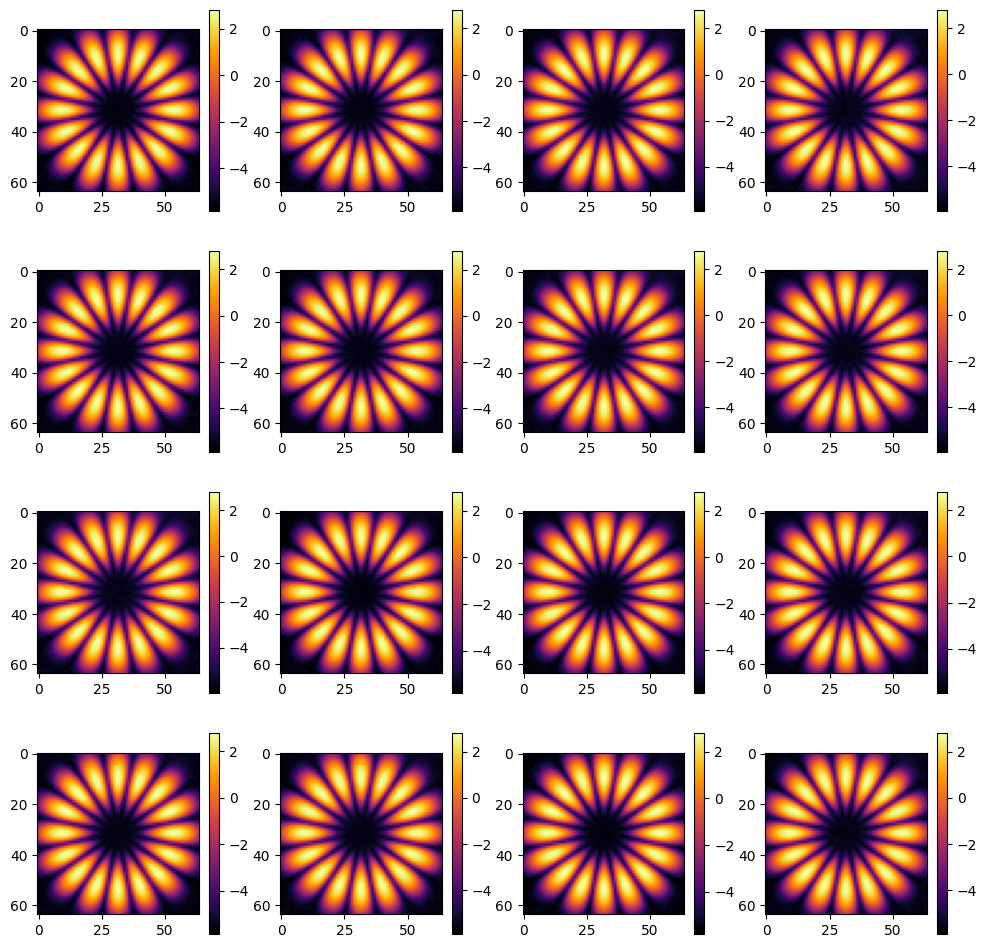

In [33]:
plt.figure(figsize = (12, 12))
draws = draws.view(-1, NPIX, NPIX)
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(draws[i], cmap = 'inferno')
    plt.colorbar()

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 2975.61it/s]


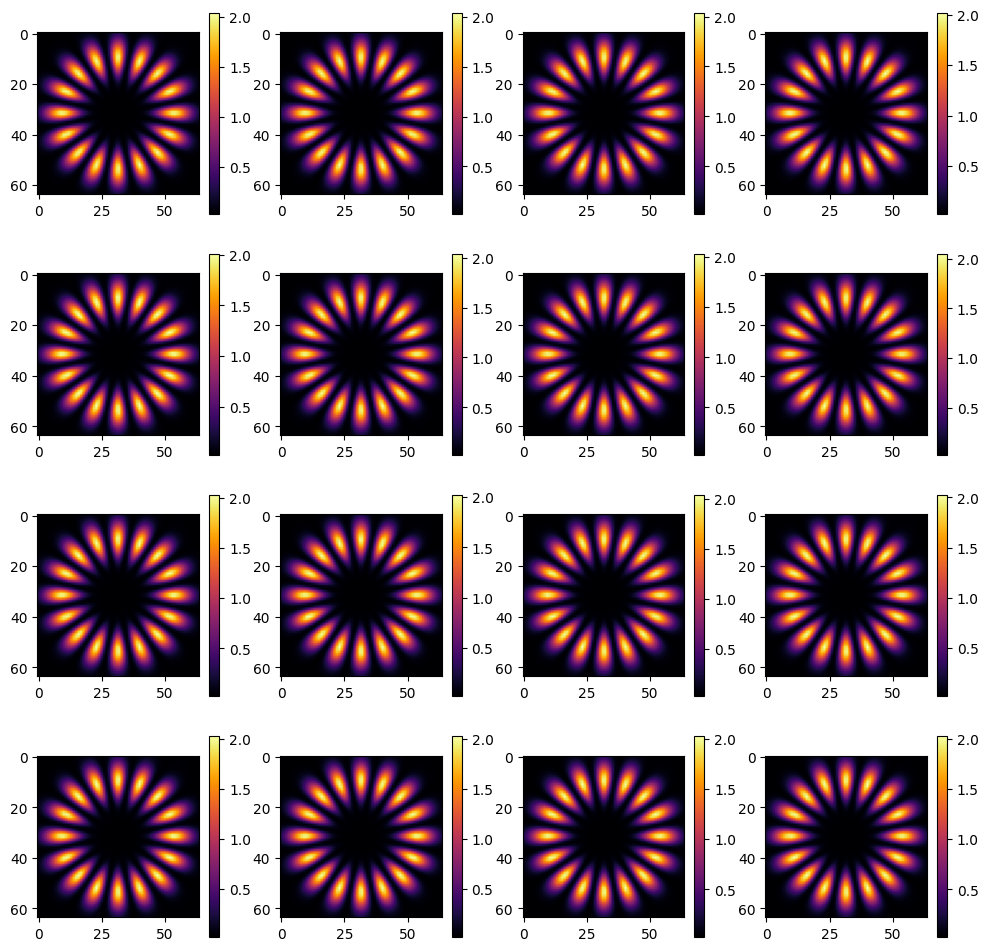

In [36]:
sim = SimulatorBlob(bounds = draws, Npix = NPIX, sigma = .01)
test_samples = sim.sample(16)
plt.figure(figsize = (12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(test_samples[i]['mu']-0*z0.numpy(), cmap = 'inferno')
    plt.colorbar()

In [37]:
bounds = draws